<a href="https://colab.research.google.com/github/mehrshad-sdtn/BSc-Thesis-Project/blob/master/notebooks/augmented_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import glob
import pathlib
import PIL, PIL.Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from keras import backend as K

In [ ]:
base_dir = '/content/drive/MyDrive'
data_dir = os.path.join(base_dir, 'BSc_Project', 'out')
a_dataset = os.path.join(data_dir, 'A')
models_path = os.path.join(base_dir, 'BSc_Project', 'models')

In [ ]:
batch_size = 128
img_height = 224
img_width = 224

In [ ]:
def load_image(filepath, dims):
   image = cv2.cvtColor(
      cv2.imread(filepath), cv2.COLOR_BGR2RGB)
   image = cv2.resize(image, dims)
   image = image.astype('float32') / 255.0
   return image


def image_arrays_from_directory(directory):
  arrays = []
  counter = 0
  for i, cat in enumerate(os.listdir(directory)):
    path = os.path.join(directory, cat)
    for image in os.listdir(path):
      counter += 1
      image = load_image(os.path.join(path, image), dims=(img_height, img_width))
      arrays.append((image, 1 - i))
  print(f"{counter} images were read")
  return arrays


def train_validation_split(data_array, ratio):
  length = int(ratio * len(data_array))
  return data_array[length:], data_array[:length]

In [ ]:
dataset_images = image_arrays_from_directory(a_dataset)
dataset_images[0]

948 images were read


(array([[[0.12156863, 0.5764706 , 0.54509807],
         [0.12156863, 0.5764706 , 0.54509807],
         [0.12156863, 0.5764706 , 0.54509807],
         ...,
         [0.12156863, 0.5764706 , 0.54509807],
         [0.12156863, 0.5764706 , 0.54509807],
         [0.12156863, 0.5764706 , 0.54509807]],
 
        [[0.13333334, 0.5372549 , 0.5529412 ],
         [0.13333334, 0.5372549 , 0.5529412 ],
         [0.13333334, 0.5372549 , 0.5529412 ],
         ...,
         [0.11764706, 0.6156863 , 0.53333336],
         [0.11764706, 0.6156863 , 0.53333336],
         [0.11764706, 0.6156863 , 0.53333336]],
 
        [[0.11764706, 0.6156863 , 0.53333336],
         [0.11764706, 0.6156863 , 0.53333336],
         [0.11764706, 0.6156863 , 0.53333336],
         ...,
         [0.1254902 , 0.5686275 , 0.54901963],
         [0.1254902 , 0.5686275 , 0.54901963],
         [0.1254902 , 0.5686275 , 0.54901963]],
 
        ...,
 
        [[0.92941177, 0.8980392 , 0.10588235],
         [0.92941177, 0.8980392 , 0.10588

In [ ]:
import random
random.seed(123)
random.shuffle(dataset_images)
train, validation = train_validation_split(dataset_images, ratio=0.2)

In [ ]:
len(train), len(validation)

(759, 189)

In [ ]:
def seperate_lebale(paired_data):
  X = np.array([data for data, label in paired_data])
  y = np.array([label for data, label in paired_data])
  return X, y


X_train, y_train = seperate_lebale(train)
X_valid, y_valid = seperate_lebale(validation)

In [ ]:
X_train.shape, y_train.shape

((759, 224, 224, 3), (759,))

####**CNN classification model**
First we train the CNN on the unaugmented dataset to obtain the baseline results for comparison to augmented data



In [ ]:
tf.random.set_seed(123)
np.random.seed(123)

num_classes = 2

vgg16_model = keras.Sequential()
vgg16_model.add(layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16_model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Flatten())
vgg16_model.add(layers.Dense(4096,activation="relu"))
vgg16_model.add(layers.Dense(4096,activation="relu"))
vgg16_model.add(layers.Dense(num_classes, activation="softmax"))
vgg16_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
vgg16_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

vgg16_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=70, batch_size=128, shuffle=False)

Epoch 1/70
6/6 [==============================] - 65s 7s/step - loss: 0.6935 - accuracy: 0.5072 - val_loss: 0.6903 - val_accuracy: 0.5767
Epoch 2/70
6/6 [==============================] - 11s 2s/step - loss: 0.6927 - accuracy: 0.5204 - val_loss: 0.6878 - val_accuracy: 0.5767
Epoch 3/70
6/6 [==============================] - 11s 2s/step - loss: 0.6914 - accuracy: 0.5204 - val_loss: 0.6814 - val_accuracy: 0.5767
Epoch 4/70
6/6 [==============================] - 11s 2s/step - loss: 0.6864 - accuracy: 0.5204 - val_loss: 0.6635 - val_accuracy: 0.5767
Epoch 5/70
6/6 [==============================] - 12s 2s/step - loss: 0.7410 - accuracy: 0.5758 - val_loss: 0.7315 - val_accuracy: 0.5291
Epoch 6/70
6/6 [==============================] - 12s 2s/step - loss: 0.6979 - accuracy: 0.5138 - val_loss: 0.6925 - val_accuracy: 0.6667
Epoch 7/70
6/6 [==============================] - 12s 2s/step - loss: 0.6923 - accuracy: 0.5441 - val_loss: 0.6883 - val_accuracy: 0.5767
Epoch 8/70
6/6 [==================

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([364, 395]))


### **Classification on VAE augmented dataset**
---


Loading the VAE model

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
def load_autoencoder(names):
  """
  names is a dictionary containing 'decoder' and 'encoder' names
  """
  encoder = keras.models.load_model(os.path.join(models_path, names['encoder']), custom_objects={'Sampling':Sampling}) 
  decoder = keras.models.load_model(os.path.join(models_path, names['decoder']))
  return encoder, decoder 


tf.random.set_seed(42)
np.random.seed(42)

latent_dim = 512

tf.random.set_seed(42)
np.random.seed(42)

latent_dim = 1024


def encoder(inputs):
  # (224, 224, 3)

  x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs) 
  # (112, 112, 32)

  x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
  # (56, 56, 64)

  x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
  # (28, 28, 128)

  x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
  # (14, 14, 256)

  x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)
  # (7, 7, 512)

  x = layers.Flatten()(x)
  x = layers.Dense(2048, activation="relu")(x)

  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  v_encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
  v_encoder.summary()
  return v_encoder, z_log_var, z_mean


def decoder():
  latent_inputs = keras.Input(shape=(latent_dim,))

  x = layers.Dense(2048, activation="relu")(latent_inputs)
  x = layers.Dense(7*7*512, activation="relu")(x)
  x = layers.Reshape((7, 7, 512))(x)

  x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
  # (14, 14, 256)

  x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
  # (28, 28, 128)

  x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  # (56, 56, 64)

  x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
  # (112, 112, 32)

  decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid",  strides=2, padding="same")(x)
  v_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  v_decoder.summary()
  return v_decoder


inputs = keras.layers.Input(shape=(224, 224, 3))
norm_encoder, norm_codings_log_var, norm_codings_mean = encoder(inputs)
norm_decoder = decoder()
_, _, norm_codings = norm_encoder(inputs)
norm_reconstructions = norm_decoder(norm_codings)
norm_vae = keras.models.Model(inputs=[inputs], outputs=[norm_reconstructions])

latent_loss = -0.5 * K.sum(1 + norm_codings_log_var - K.exp(norm_codings_log_var) - K.square(norm_codings_mean), axis=-1)


inputs = keras.layers.Input(shape=(224, 224, 3))
sch_encoder, sch_codings_log_var, sch_codings_mean = encoder(inputs)
sch_decoder = decoder()
_, _, sch_codings = sch_encoder(inputs)
sch_reconstructions = sch_decoder(sch_codings)
sch_vae = keras.models.Model(inputs=[inputs], outputs=[sch_reconstructions])

sch_latent_loss = -0.5 * K.sum(1 + sch_codings_log_var - K.exp(sch_codings_log_var) - K.square(sch_codings_mean), axis=-1)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 56, 56, 64)   18496       ['conv2d[0][0]']                 
                                                                                            

In [ ]:
norm_encoder, norm_decoder = load_autoencoder({'encoder': 'norm_encoder_v3.h5', 'decoder': 'norm_decoder_v3.h5'})

In [ ]:
sch_encoder, sch_decoder = load_autoencoder({'encoder': 'sch_encoder_v3.h5', 'decoder': 'sch_decoder_v3.h5'})

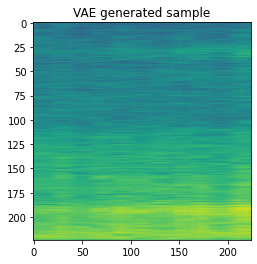

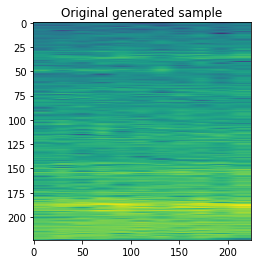

In [ ]:
codings = tf.random.normal(shape=[1, latent_dim])
images = sch_decoder(codings).numpy()
plt.title('VAE generated sample')
plt.imshow(np.squeeze(images))
plt.show()

plt.title('Original generated sample')
plt.imshow(X_train[1])
plt.show()

In [ ]:
def generate_synth_data(decoder):
  codings = tf.random.normal(shape=[1, latent_dim])
  images = decoder(codings).numpy()
  return np.squeeze(images)

generate_synth_data(norm_decoder).shape

(224, 224, 3)

In [ ]:
count = 150
synth_sch = [(generate_synth_data(sch_decoder), 1) for i in range(0, count)]
synth_norm = [(generate_synth_data(norm_decoder), 0) for i in range(0, count + 20)]
synth_dataset = []
synth_dataset.extend(synth_sch)
synth_dataset.extend(synth_norm)

In [ ]:
random.shuffle(synth_dataset)
X_syn, y_syn = seperate_lebale(synth_dataset)
print(X_syn.shape, y_syn.shape)

(320, 224, 224, 3) (320,)


In [ ]:
X_aug, y_aug = np.concatenate([X_train, X_syn]), np.concatenate([y_train, y_syn])

In [ ]:
print(np.unique(y_aug, return_counts=True))
print(X_aug.shape, y_aug.shape)

(array([0, 1]), array([534, 545]))
(1079, 224, 224, 3) (1079,)


In [ ]:
tf.random.set_seed(123)
np.random.seed(123)

num_classes = 2

augmented_model = keras.Sequential()
augmented_model.add(layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
augmented_model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
augmented_model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
augmented_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
augmented_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
augmented_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
augmented_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
augmented_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
augmented_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
augmented_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
augmented_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
augmented_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
augmented_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
augmented_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
augmented_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
augmented_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
augmented_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
augmented_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
augmented_model.add(layers.Flatten())
augmented_model.add(layers.Dense(4096,activation="relu"))
augmented_model.add(layers.Dense(4096,activation="relu"))
augmented_model.add(layers.Dense(num_classes, activation="softmax"))
augmented_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
augmented_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
augmented_model.fit(X_aug, y_aug, validation_data=(X_valid, y_valid), epochs=70, batch_size=128, shuffle=False)

Epoch 1/70
9/9 [==============================] - 51s 4s/step - loss: 0.6939 - accuracy: 0.4958 - val_loss: 0.6921 - val_accuracy: 0.5767
Epoch 2/70
9/9 [==============================] - 17s 2s/step - loss: 0.6932 - accuracy: 0.5051 - val_loss: 0.6928 - val_accuracy: 0.5767
Epoch 3/70
9/9 [==============================] - 17s 2s/step - loss: 0.6932 - accuracy: 0.5051 - val_loss: 0.6930 - val_accuracy: 0.5767
Epoch 4/70
9/9 [==============================] - 17s 2s/step - loss: 0.6932 - accuracy: 0.4921 - val_loss: 0.6931 - val_accuracy: 0.5767
Epoch 5/70
9/9 [==============================] - 17s 2s/step - loss: 0.6932 - accuracy: 0.4699 - val_loss: 0.6931 - val_accuracy: 0.5238
Epoch 6/70
9/9 [==============================] - 17s 2s/step - loss: 0.6930 - accuracy: 0.5366 - val_loss: 0.6936 - val_accuracy: 0.4339
Epoch 7/70
9/9 [==============================] - 17s 2s/step - loss: 0.6844 - accuracy: 0.5514 - val_loss: 0.8326 - val_accuracy: 0.4709
Epoch 8/70
9/9 [==================

**Augmented Data yields 2% improvements over the normal classification (so far)**

In [ ]:
augmented_model.save(os.path.join(models_path, 'augmented_model.h5'))